In [137]:
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")
from model_operators import *
from utils import *

In [138]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
from models_and_guides import *

In [146]:
factor = nx.DiGraph()

In [147]:
nodes = [
    ('cov_diag_loc',{'type':'param','shape':'D'}),
    ('cov_diag_scale',{'type':'param','shape':'D','constraint':'positive'}),
    ('cov_factor_loc',{'type':'param','shape':'KD'}),
    ('cov_factor_scale',{'type':'param','shape':'KD','constraint':'positive'}),
    ('z_loc',{'type':'const', 'value':0.}),
    ('z_scale',{'type':'const', 'value':1.}),
    ('z',{'distribution':dist.Normal,'type':'latent'}),
    ('cov_factor',{'distribution':dist.Normal,'type':'latent'}),
    #('Wz',{'type':'deterministic', 'function':torch.matmul}),
    ('Wz',{'type':'deterministic', 'function':torch.matmul}),
    ('X',{'distribution':dist.MultivariateNormal,'type':'obs'}),
    ('cov_diag',{'distribution':dist.LogNormal,'type':'latent'}),
    ('diag',{'type':'deterministic', 'function':torch.diag}),
]

In [148]:
edges = [
    ('cov_diag_loc','cov_diag',{'type':'param','param':'loc'}),
    ('cov_diag_scale','cov_diag',{'type':'param','param':'scale'}),
    ('cov_factor_loc','cov_factor',{'type':'param','param':'loc'}),
    ('cov_factor_scale','cov_factor',{'type':'param','param':'scale'}),
    ('z_loc','z',{'type':'param','param':'loc'}),
    ('z_scale','z',{'type':'param','param':'scale'}),    
    #('z','Wz',{'type':'arg', 'transpose':True}),
    ('z','Wz',{'type':'arg', 'transpose':lambda x,y: torch.matmul(x.transpose(),y)}),
    ('cov_factor','Wz',{'type':'arg'}),
    ('Wz','X',{'type':'param','param':'loc'}),
    #('cov_diag','X',{'type':'param','param':'scale'})
    ('cov_diag','diag',{'type':'arg'}),
    ('diag','X',{'type':'param','param':'scale'})
]

In [149]:
plate_attr = {
    'cov_factor':{'plates':['D','K']},
    'cov_diag':{'plates':['D']},
    'X':{'plates':['N']},
    'Wz':{'plates':['N']},
    'z':{'plates':['N','K']}
}

In [150]:
factor.add_nodes_from(nodes)
factor.add_edges_from(edges)
nx.set_node_attributes(factor, plate_attr)

W: D, K

z: K, N

Sigma: D

Wz: N

X: N

In [343]:
nx.get_node_attributes(factor, 'plates')

{'z': ['N', 'K'],
 'cov_factor': ['D', 'K'],
 'Wz': ['N'],
 'X': ['N'],
 'cov_diag': ['D']}

In [362]:
def remove_nodes_keep_edges(G, nodes):
    for node in nodes:
        # connect orphaned children to grandparents
        parents = [u for u,v in G.in_edges(node)]
        children = [v for u,v in G.out_edges(node)]
        G.add_edges_from([(u,v) for u,v in zip(parents,children)])
        G.remove_node(node)

In [408]:
def make_plate_graph(DAG):
    # make dependency graph of all plates
    plate_graph = DAG.copy()
    non_plated = [node for node in plate_graph.nodes if 'plates' not in plate_graph.nodes[node].keys()]
    remove_nodes_keep_edges(plate_graph, non_plated)
    for u,v in plate_graph.in_edges:
        try:
            if plate_graph.nodes[v]['plates'] == plate_graph.nodes[u]['plates']:
                plate_graph = nx.algorithms.minors.contracted_nodes(plate_graph,u,v, self_loops=False)
        except KeyError:
            continue
    plate_graph = nx.relabel_nodes(plate_graph, {node:''.join(plate_graph.nodes[node]['plates']) for node in plate_graph.nodes})
    
    # merge the plates that can be merged
    nodes_to_merge = []
    for node in plate_graph.nodes:
        node_to_remove = [other_node for other_node in plate_graph.nodes if node != other_node and (node.startswith(other_node))]
        if node_to_remove:
            nodes_to_merge.append((node, node_to_remove[0]))

    for u,v in nodes_to_merge:
        plate_graph = nx.algorithms.minors.contracted_nodes(plate_graph,u,v, self_loops=False)
    return plate_graph

In [419]:
plate_graph = make_plate_graph(factor)

/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


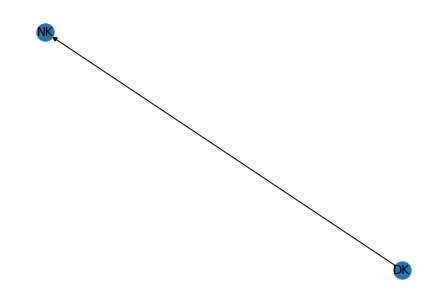

In [420]:
nx.draw(plate_graph, with_labels = True)

In [411]:
plate_graph = make_plate_graph(marg_factor)

In [423]:
list(nx.topological_sort(plate_graph))

['DK', 'NK']

/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


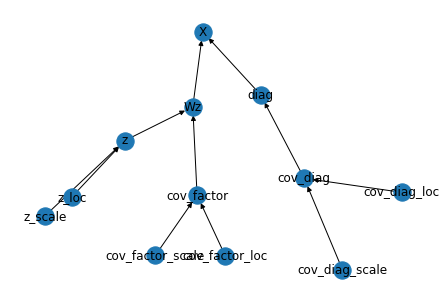

In [152]:
nx.draw(factor, with_labels=True)

In [11]:
def construct_initalization(graph, node):
    if graph.nodes[node]['type'] == 'param':
        return Assign(targets=[Name(id=node+'_init')],
            value=Subscript(value=Attribute(value=Name(id='self'), attr='param_init'),
                slice=Index(
                    value=JoinedStr(
                        values=[Str(s=node+'_init_'),
                            FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]))))

In [12]:
def construct_param(graph, node):
    if graph.nodes[node]['type'] == 'param':
        # need to infer constraint
        if 'constraint' not in graph.nodes[node].keys():
            constraint = []
        else:
            constraint = [keyword(arg='constraint', value=Attribute(value=Name(id='constraints'), attr=graph.nodes[node]['constraint']))]
        return Assign(targets=[Name(id=node)],
                value=Call(func=Attribute(value=Name(id='pyro'), attr='param'),
                    args=[
                        JoinedStr(
                            values=[Str(s=node+'_'),
                                FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]),
                        Name(id=node+'_init')],
                    keywords=constraint))
    elif graph.nodes[node]['type'] == 'const':
        return Assign(targets=[Name(id=node)], value=Num(n=graph.nodes[node]['value']))
    else:
        raise "Root nodes must be either parameters or constants."

In [443]:
dist.LowRankMultivariateNormal.arg_constraints.keys()

dict_keys(['loc', 'cov_factor', 'cov_diag'])

In [461]:
def construct_sample(graph, node):
    if 'distribution' in graph.nodes[node]:
        distribution = graph.nodes[node]['distribution']
        # go through the args of the distribution, find matching ingoing node, 
        # construct distribution with ingoing nodes as arguments
        args = []
        for param in distribution.arg_constraints.keys():
            arg = [edge[0] for edge in graph.in_edges(node) if graph.edges[edge]['param'] == param][0]
            args.append(Name(id=arg))
        # assuming node is a loc-scale distribution
        #loc = [edge[0] for edge in graph.in_edges(node) if graph.edges[edge]['param'] == 'loc'][0]
        #scale = [edge[0] for edge in graph.in_edges(node) if graph.edges[edge]['param'] == 'scale'][0]
        # get string repr of distribution
        dist = ''.join(c for c in str(distribution).split('.')[-1] if c.isalnum())
        dist = Call(func=Attribute(value=Name(id='dist'), attr=dist),
                                args=args,
                                keywords=[])
        if graph.nodes[node]['type'] == 'latent':
            node_name = JoinedStr(
                                values=[Str(s=node+'_'),
                                    FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)])
            keywords = []
        elif graph.nodes[node]['type'] == 'obs':
            node_name = Str(s='obs')
            # assuming this is wrapped in a with pyro.plate(subsampling) as ind:
            keywords = [keyword(arg='obs',
                                value=Call(func=Attribute(value=Name(id='X'), attr='index_select'),
                                    args=[Num(n=0), Name(id='ind')],
                                    keywords=[]))]
        return Assign(targets=[Name(id=node)],
                    value=Call(func=Attribute(value=Name(id='pyro'), attr='sample'),
                        args=[node_name,
                            dist],
                        keywords=keywords))
            
    elif graph.nodes[node]['type'] == 'deterministic':
        # assuming function is a torch method, s.t. calling it looks like torch.method(arg1,arg2,...,argN)
        # get string repr of function
        function = graph.nodes[node]['function'].__name__
        args = []
        for edge in graph.in_edges(node):
            assert graph.edges[edge]['type'] == 'arg'
            if 'transpose' in graph.edges[edge]:
                args.append(Call(func=Attribute(value=Name(id=edge[0]), attr='transpose'), args=[Num(n=0), Num(n=1)], keywords=[]))
            else:
                args.append(Name(id=edge[0]))
        return Assign(targets=[Name(id=node)],
            value=Call(func=Attribute(value=Name(id='pyro'), attr='deterministic'),
                args=[
                    JoinedStr(
                            values=[Str(s=node+'_'),
                                FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]),
                    Call(func=Attribute(value=Name(id='torch'), attr=function),
                        args=args,
                        keywords=[])],
                keywords=[]))

In [445]:
def construct_plate(graph, plate):
    if plate == 'N':
        keywords = [keyword(arg='subsample_size', value=Attribute(value=Name(id='self'), attr='batch_size'))]
        optional_vars=Name(id='ind')
    else: 
        keywords = []
        optional_vars=None
    return With(
            items=[withitem(
                    context_expr=Call(func=Attribute(value=Name(id='pyro'), attr='plate'),
                        args=[
                            JoinedStr(
                                values=[Str(s=plate+'_'),
                                    FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]),
                            Name(id=plate[-1])],
                        keywords=keywords),
                    optional_vars=optional_vars)
                ],
            body=[Pass])

In [446]:
def insert_function_into_class(class_source, function_code, function_def_str, function_return_str):
    start_idx = class_source.find(function_def_str)
    end_idx = class_source.find(function_return_str) + len(function_return_str)
    # add indentation
    function_code = function_code.replace('\n    ','\n        ')
    return class_source.replace(class_source[start_idx:end_idx], function_code)

In [463]:
def generate_model(DAG, dims, root_node_suffix = None):
    # rename root nodes
    if root_node_suffix != None:
        root_node_names = [node for node in DAG.nodes if DAG.in_degree[node] == 0]
        new_root_node_names = ['_'.join(node.split('_')[:-1] + [root_node_suffix] + node.split('_')[-1:]) for node in root_node_names]
        mapping = dict(zip(root_node_names, new_root_node_names))
        DAG = nx.relabel_nodes(DAG, mapping, copy=True)
    # get template source
    source = inspect.getsource(DAGModel.model).strip()
    tree = parse(source)
    # figure out which plates to create and in what order
#    plates = [''.join(plate) for plate in nx.get_node_attributes(DAG, 'plates').values()]
#    new_plates = []
#    for plate in plates:
#        if not any([other_plate.startswith(plate) for other_plate in plates if other_plate != plate]):
#            new_plates.append(plate)
    plate_graph = make_plate_graph(DAG)
    new_plates = list(nx.topological_sort(plate_graph))
    # create plates
    for plate_config in new_plates:
        prev_plate = plate_config[0]
        AddToFunctionBody(construct_plate(DAG, prev_plate), pos=-1).visit(tree)
        for plate in plate_config[1:]:
            AddToPlate(prev_plate, construct_plate(DAG, prev_plate+plate)).visit(tree)
            prev_plate = plate
    # create all nodes in DAG
    for node in nx.topological_sort(DAG):
        # if it's a root node, add it top level in the function
        if DAG.in_degree[node] == 0:
            # edit model tree
            AddToFunctionBody(construct_param(DAG, node), pos=0).visit(tree)
            AddToFunctionBody(construct_initalization(DAG, node), pos=0).visit(tree)
        # if not, check for plating, and maintain dependency order unplated nodes
        else:
            if 'plates' in DAG.nodes[node]:
                plate = ''.join(DAG.nodes[node]['plates'])
                AddToPlate(plate, construct_sample(DAG, node)).visit(tree)
            else:
                # WARNING: This is not general enough, will fail sooner or later
                # find plate containing parent of node
                parents = [edge[0] for edge in factor.in_edges(node)]
                parent_plate = DAG.nodes[parents[0]]['plates']
                # find index of plate containing parent of node
                pos = [i for i,elem in enumerate(tree.body[0].body) if (type(elem) == ast.With and elem.items[0].context_expr.args[0].values[0].s == parent_plate[0]+'_')]
                pos = pos[0] + 1
                AddToFunctionBody(construct_sample(DAG, node), pos=pos).visit(tree)
    # add _id to model
    AddToFunctionBody(Assign(targets=[Name(id='_id')], value=Attribute(value=Name(id='self'), attr='_id')), pos=0).visit(tree)
    # add shape assignment
    get_data_shape = Assign(targets=[Tuple(elts=[Name(id='N'), Name(id='D')])], value=Attribute(value=Name(id='X'), attr='shape'))
    AddToFunctionBody(get_data_shape).visit(tree)
    # add dim definitions
    for dim in dims:
        AddToFunctionBody(Assign(targets=[Name(id=dim)], value=Attribute(value=Name(id='self'), attr=dim))).visit(tree)
    return tree

In [448]:
def generate_get_param_shapes_and_support_and_init(DAG):
    param_shape_keys = []
    param_shape_vals = []
    shape_dims = []
    for node in nx.topological_sort(DAG):
        if DAG.nodes[node]['type'] == 'param':
            if 'constraint' in DAG.nodes[node]:
                constraint = DAG.nodes[node]['constraint']
            else:
                constraint = 'real'
                
            prior_param = '_'.join(node.split('_')[:-1] + ['prior'] + node.split('_')[-1:])
            
            param_shape_keys.append(JoinedStr(values=[Str(s=node+'_init_'),
                                FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]))
            param_shape_keys.append(JoinedStr(values=[Str(s=prior_param+'_init_'),
                                FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]))

            shape_elts = [Attribute(value=Name(id='self'), attr=dim) for dim in DAG.nodes[node]['shape']]
            param_shape_vals.append(Tuple(elts=[Tuple(elts=shape_elts),
                            Attribute(value=Name(id='constraints'), attr=constraint)]))
            param_shape_vals.append(Tuple(elts=[Tuple(elts=shape_elts),
                            Attribute(value=Name(id='constraints'), attr=constraint)]))
            if DAG.nodes[node]['shape'] not in shape_dims:
                shape_dims.append(DAG.nodes[node]['shape'])

    # construct get_param_shapes_and_support()
    get_param_shape_source = inspect.getsource(DAGModel.get_param_shapes_and_support).strip()
    get_param_shape_tree = parse(get_param_shape_source)
    
    AddReturn(Dict(keys=param_shape_keys,values=param_shape_vals)).visit(get_param_shape_tree)
    
    # edit __init__()
    init_source = inspect.getsource(DAGModel.__init__).strip()
    init_tree = parse(init_source)
    dims = [dim for shape in shape_dims for dim in shape if dim not in 'ND']
    for dim in dims:
        AddArgsToFunctionDef(dim,pos=2).visit(init_tree)
        AddToFunctionBody(Assign(targets=[Attribute(value=Name(id='self'), attr=dim)], value=Name(id=dim))).visit(init_tree)
    return get_param_shape_tree, init_tree, dims

In [449]:
def generate_guide(DAG, dims):
    guide_DAG = DAG.copy()
    # remove X
    # remove nodes connected to X that aren't latent nodes
    # properly we should recursively remove nodes that lead to X that aren't latent nodes until we reach latent nodes,
    # but in this case we just have one layer of deterministic nodes
    # so we'll worry about the general case later
    nodes_to_remove = ['X']
    in_nodes = [edge[0] for edge in guide_DAG.in_edges('X') if guide_DAG.nodes[edge[0]]['type'] != 'latent']
    nodes_to_remove.extend(in_nodes)
    guide_DAG.remove_nodes_from(nodes_to_remove)
    tree = generate_model(guide_DAG, dims)
    ChangeFunctionName('guide').visit(tree)
    CutFromFunctionBody(head=False).visit(tree)
    AddReturn(tuple([node for node in guide_DAG.nodes if guide_DAG.nodes[node]['type'] == 'latent'])).visit(tree)
    return tree

In [450]:
def generate_Model_class(DAG):
    get_param_shape_tree, init_tree, dims = generate_get_param_shapes_and_support_and_init(DAG)
    tree = generate_model(DAG, dims, root_node_suffix = 'prior')
    guide_tree = generate_guide(DAG, dims)

    # write source code
    fix_missing_locations(tree)
    model_source = astor.to_source(tree)
    
    fix_missing_locations(get_param_shape_tree)
    get_param_shape_source = astor.to_source(get_param_shape_tree)

    fix_missing_locations(init_tree)
    init_source = astor.to_source(init_tree)

    fix_missing_locations(guide_tree)
    guide_source = astor.to_source(guide_tree)

    class_source = inspect.getsource(DAGModel).strip()
    # insert source code
    class_source = insert_function_into_class(class_source, init_source, 'def __init__', 'super(DAGModel, self).__init__(X, batch_size, _id)')    
    class_source = insert_function_into_class(class_source, get_param_shape_source, 'def get_param_shapes_and_support', '_id = self._id')    
    class_source = insert_function_into_class(class_source, model_source, 'def model', 'return X')    
    class_source = insert_function_into_class(class_source, guide_source, 'def guide', 'raise NotImplementedError')    

    #class_source = parse(class_source)
    #fix_missing_locations(class_source)
    #class_source = astor.to_source(class_source)
    #print(class_source)
    # write to file
    with open("model.py", "w") as output:
        output.write('from models_and_guides import *\n\n')
        output.writelines(class_source)

In [429]:
generate_Model_class(factor)

['DK', 'NK']
['DK', 'NK']


In [45]:
pyro.clear_param_store()

In [46]:
from model import DAGModel

In [47]:
N = 1000
D = 10
K = 4

In [48]:
dagmodel = DAGModel(torch.zeros(N,D),K,N,'id')

In [49]:
dagmodel.batch_size = N

In [50]:
tmp = dagmodel.model(torch.zeros(N,D))

/home/folzd/anaconda3/lib/python3.7/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at diag_id
  RuntimeWarning)


In [51]:
tmp.shape

torch.Size([1000, 10])

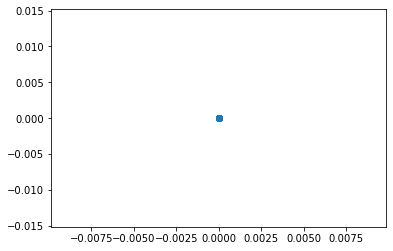

In [52]:
plt.scatter(*tmp[:,:2].detach().T)

In [53]:
foo = dagmodel.unconditioned_model(torch.zeros(N,D))

In [54]:
pyro.clear_param_store()

In [55]:
pyro.set_rng_seed(42)

zeroMeanFactor_teacher = ZeroMeanFactor(torch.empty(N,D), K, N, '0')

dgp = zeroMeanFactor_teacher.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()

data, test_data = train_test_split(X)

In [56]:
data.shape

torch.Size([900, 10])

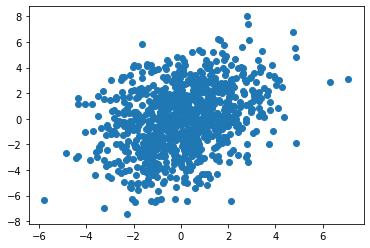

In [57]:
plt.scatter(*data[:,:2].T)

In [58]:
from inference import *

In [63]:
config = dict(
        n_iter = 1000,
        learning_rate = 0.1, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [64]:
inference(dagmodel, data, test_data, config=config)



NLL after 0/1000 iterations is 25.63686752319336
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

{'gradient_norms': defaultdict(list, {}),
 'loss': [32237.593715667725,
  26750.483726501465,
  26225.419261932373,
  25580.07061767578,
  24311.253183364868,
  24733.016563415527,
  24733.772773742676,
  25599.737047195435,
  24326.52151298523,
  24088.752500534058,
  22904.523874282837,
  23985.01446723938,
  24450.938678741455,
  27805.379994392395,
  23702.997121810913,
  23470.645705461502,
  22952.39949655533,
  23661.97674369812,
  23689.903207302094,
  22642.308037757874,
  23918.30840063095,
  22519.53001832962,
  22671.907781124115,
  23002.39107608795,
  24016.244009017944,
  22820.370732188225,
  23081.719715595245,
  22480.61115503311,
  22446.982175827026,
  23036.080585479736,
  23799.941381454468,
  22624.40024292469,
  22641.49090051651,
  22921.90753173828,
  22633.06422519684,
  22340.570791244507,
  23724.160215377808,
  22943.364203453064,
  22168.98233318329,
  22320.649886131287,
  22290.847278118134,
  24893.745219230652,
  22980.82049226761,
  22538.97120094299

In [74]:
dagmodel.sample_posterior_predictive(N)

In [75]:
foo = dagmodel.posterior_predictive(data)

In [76]:
foo['cov_diag_id'].shape

torch.Size([1000, 1, 10])

In [77]:
foo['obs'].shape

torch.Size([1000, 32, 32, 10])

In [91]:
rand_idx = np.random.choice(10,2)

In [92]:
rand_idx

array([1, 3])

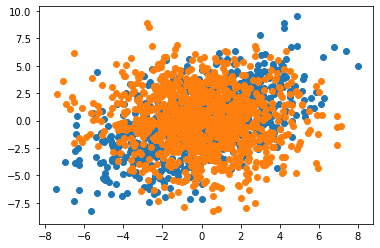

In [93]:
plt.scatter(*data[:,rand_idx].T)
plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [97]:
foo['z_id'].shape

torch.Size([1000, 4, 32])

In [451]:
marg_factor = factor.copy()

In [452]:
marg_factor.nodes['X']['distribution'] = dist.LowRankMultivariateNormal

In [453]:
marg_factor.add_nodes_from([('loc',{'type':'const', 'value':0.}),])
#marg_factor.add_nodes_from([('loc',{'type':'const', 'value':torch.zeros(D)}),])

In [454]:
marg_factor.add_edges_from([
    ('cov_factor','X',{'type':'param','param':'cov_factor'}),
    ('cov_diag','X',{'type':'param','param':'cov_diag'}),
    ('loc','X',{'type':'param','param':'loc'})
    ])

In [455]:
parents = [u for u,v in marg_factor.in_edges('z')]

In [456]:
marg_factor.remove_nodes_from(['Wz','z','diag']+parents)

/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


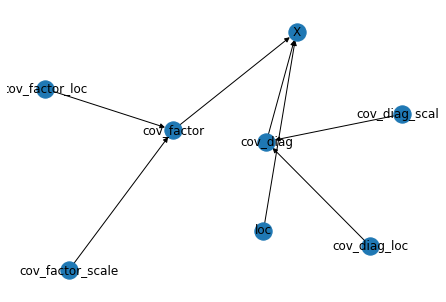

In [457]:
nx.draw(marg_factor, with_labels=True)

In [462]:
generate_Model_class(marg_factor)

['DK', 'N']
['DK']


In [474]:
from model import DAGModel

In [475]:
pyro.clear_param_store()

In [476]:
dagmodel = DAGModel(torch.zeros(N,D),K,N,'id')

In [477]:
tmp = dagmodel.model(torch.zeros(N,D))

ValueError: cov_factor must be a batch of matrices with shape 10 x m